# 5. Interesting Tidbits

I'll post answers to some common questions, and some interesting peculiarities here. 


## 1. Interesting failure modes!

Let's look at what is happening when we use quad to integrate. 

It is doing a numerical integral using the original QUADPACK FORTRAN 77 library for numerical integration.  (You used to have a book called "Numerical Recipes" that you had to look up to code all these yourself, but now they come as handy functions someone else has coded up for you.) 

Hopefully you've learned methods of numerical integration before, such as the trapezoidal rule and Simpson's rule.  This is basically a variant of that, where you divide the integral up into subregions, calculate the approximate integral, and keep subdividing until the difference between one step and the next goes under some tolerance.  

QUADPACK info: https://en.wikipedia.org/wiki/QUADPACK 

Note you can force it to do different types of approximations for different circumstances, and depending on your problem some will suit better.  For example if you need to integrate to infinity you can choose an approximation scheme that is optimised to that case, which may be quite different that integrating over some low numbers. 

As with all approximations these sometimes fail, though.  An interesting example of a numerical failure is Runge's phenomenon, when higher-order polynomial fitting becomes unstable at the edges of an interval. https://en.wikipedia.org/wiki/Runge%27s_phenomenon 

Here's an example of a failure mode for our integral....

### 1.1 Setup for a standard model.
Code 1/(da/dt) for the standard model with a cosmological constant and matter.
$$ \frac{\dot{a}}{a} = H_0 \left[\Omega_M a^{-3}+\Omega_K a^{-2} + \Omega_\Lambda \right]^{1/2}. $$

In [9]:
# First let's set up our packages
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate

# And set some constants
c = 299792.458 # km/s (speed of light)
H0kmsmpc = 70.  # Hubble constant in km/s/Mpc
H0s = H0kmsmpc * 3.2408e-20 # H0 in inverse seconds is H0 in km/s/Mpc * (3.2408e-20 Mpc/km)
H0y = H0s * 3.154e7 * 1.e9 # H0 in inverse Giga years is H0 in inverse seconds * (3.154e7 seconds/year) * (1e9 years / Giga year)

# Write a function for the integrand, i.e. $1/\dot{a}$ (adot inverse), for a LambdaCDM model
# I'm going to keep the constant H_0 outside the integral and add it later.
# This takes as input a, Omega_M (om), and Omega_Lambda (ol) and outputs 1/adot
def adotinv(a,om,ol):
    ok = 1.0-om-ol
    adot = a*np.sqrt((om*(a**-3)) + ((ok)*(a**-2)) + (ol))        #'Your code here (Remember to keep H_0 separate i.e. just calculate adot/H_0.)'
    return 1.0/adot

# Start by making an array of scalefactors
astart = 0.0000
astop = 2.1
astep = 0.1 # Make this finer to make the plot smoother
a_arr = np.arange(astart,astop,astep)


### 1.2 Evaluation

Now let's integrate this function for a case that we know is a bouncing universe.

C:\Users\presl\AppData\Local\Temp\ipykernel_8516\2216627472.py:17: RuntimeWarning: invalid value encountered in sqrt
  adot = a*np.sqrt((om*(a**-3)) + ((ok)*(a**-2)) + (ol))        #'Your code here (Remember to keep H_0 separate i.e. just calculate adot/H_0.)'
C:\Users\presl\AppData\Local\Temp\ipykernel_8516\898097978.py:5: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  t_Gyr = np.array([integrate.quad(adotinv, 1.0, a_end, args=(om,ol))[0] for a_end in a_arr])/H0y


Text(0, 0.5, 'scalefactor')

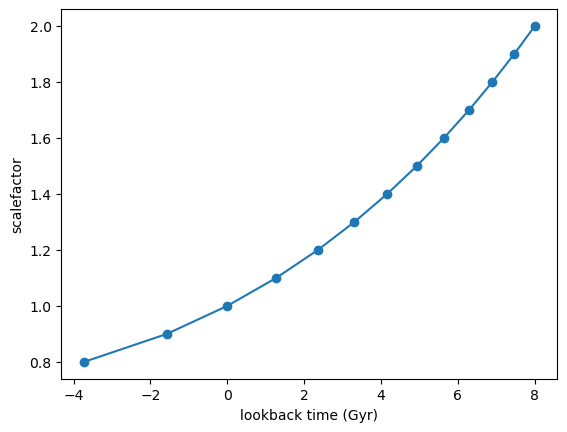

In [10]:
# Calculate for a universe that has an unstable integral! matter density 0.1 and cosmological constant 2.1
om = 0.10  
ol = 2.1

t_Gyr = np.array([integrate.quad(adotinv, 1.0, a_end, args=(om,ol))[0] for a_end in a_arr])/H0y

scatter=plt.scatter(t_Gyr,a_arr)
plt.plot(t_Gyr,a_arr)
plt.xlabel('lookback time (Gyr)')
plt.ylabel('scalefactor')

### Uh oh, something doesn't look right!

And sure enough, the integral gave a warning showing that something probably went wrong with the integral.  This behaviour is not physical, it is a result of numerical error.  Let's look more closely at the integral to find the cause. 

[           nan            nan            nan            nan
            nan            nan            nan            nan
 7.18099293e-15 1.24868993e-15 0.00000000e+00 1.01237610e-15
 1.87472443e-15 2.63096647e-15 3.30715191e-15 3.92025969e-15
 4.48209392e-15 5.05041939e-14 4.43140725e-13 2.76490948e-12
 1.33072949e-11]


C:\Users\presl\AppData\Local\Temp\ipykernel_8516\2216627472.py:17: RuntimeWarning: invalid value encountered in sqrt
  adot = a*np.sqrt((om*(a**-3)) + ((ok)*(a**-2)) + (ol))        #'Your code here (Remember to keep H_0 separate i.e. just calculate adot/H_0.)'
C:\Users\presl\AppData\Local\Temp\ipykernel_8516\3165905538.py:9: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  t_lookback_Gyr[i],uncert[i] = integrate.quad(adotinv, 1.0, a_end, args=(om,ol))
C:\Users\presl\AppData\Local\Temp\ipykernel_8516\3165905538.py:15: RuntimeWarning: divide by zero encountered in log10
  scatter=plt.scatter(t_lookback_Gyr,a_arr,c=np.log10(uncert))


Text(0, 0.5, 'scalefactor')

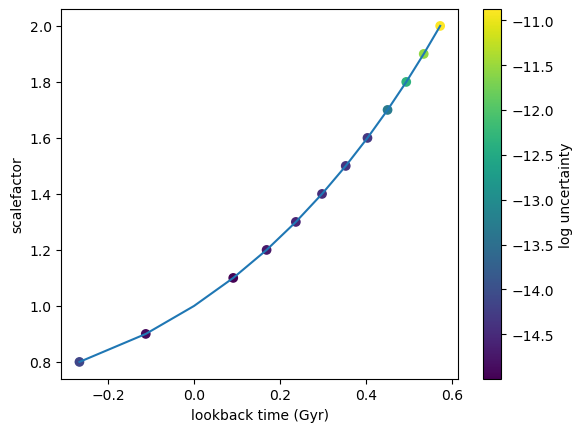

In [11]:
# Let's separate the one-line integral into it's parts.  

# integrate.quad actually returns two values... but we just chose the first of those by putting a [0] at the end. 

# Instead let's save both values.  The first is the answer to the integral, the second is the approximation of the uncertainty in the answer. 
t_lookback_Gyr = np.zeros(len(a_arr))
uncert = np.zeros(len(a_arr))
for i,a_end in enumerate(a_arr):
    t_lookback_Gyr[i],uncert[i] = integrate.quad(adotinv, 1.0, a_end, args=(om,ol))

# Now print the array of uncertainties.  You can see that most of them are down below 10**(-10), but a few are up at the 0.1 level. 
print(uncert)

# So lets redo that scatter plot, but colour code by log uncertainty (the power at the end of the number).
scatter=plt.scatter(t_lookback_Gyr,a_arr,c=np.log10(uncert))
plt.plot(t_lookback_Gyr,a_arr)
cbar = plt.colorbar(scatter)
cbar.set_label('log uncertainty')
plt.xlabel('lookback time (Gyr)')
plt.ylabel('scalefactor')


You can see that the part where the integral looks like it goes crazy, is indeed the part where the code is telling you the integral had a large uncertainty (and therefore probably failed).  

## Solution, select only those points where the integral worked. 

[7.18099293e-15 1.24868993e-15 0.00000000e+00 1.01237610e-15
 1.87472443e-15 2.63096647e-15 3.30715191e-15 3.92025969e-15
 4.48209392e-15 5.05041939e-14 4.43140725e-13 2.76490948e-12
 1.33072949e-11]


C:\Users\presl\AppData\Local\Temp\ipykernel_8516\2668970717.py:2: RuntimeWarning: divide by zero encountered in log
  i_good = np.log(uncert) < -10   # Select the indices corresponding to low uncertainty.
C:\Users\presl\AppData\Local\Temp\ipykernel_8516\2668970717.py:9: RuntimeWarning: divide by zero encountered in log10
  scatter=plt.scatter(t_good,a_good,c=np.log10(uncert[i_good]))


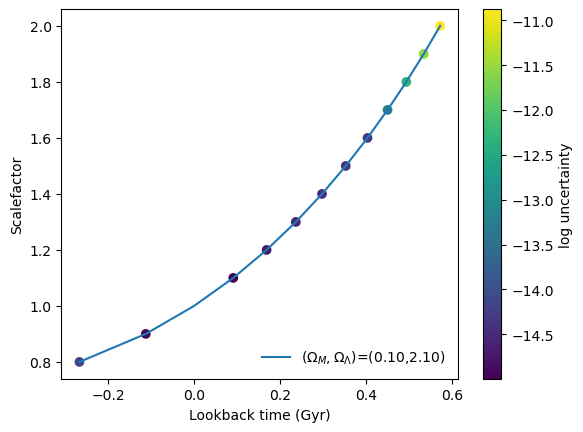

In [12]:
# Choose only those integrals that converged
i_good = np.log(uncert) < -10   # Select the indices corresponding to low uncertainty.
t_good = t_lookback_Gyr[i_good] # Select the times corresponding to those low-uncertainty points.
a_good = a_arr[i_good]          # Select the scalefactors corresponding to those low-uncertainty points. 

print (uncert[i_good])
# Plot this new model (note I've added a label that can be used in the legend)
#plt.plot(t_lookback_Gyr, a_arr,'.',label='$(\Omega_M,\Omega_\Lambda)$=(%.2f,%.2f)'%(om,ol))
scatter=plt.scatter(t_good,a_good,c=np.log10(uncert[i_good]))
plt.plot(t_good,a_good,label='$(\Omega_M,\Omega_\Lambda)$=(%.2f,%.2f)'%(om,ol)) 
cbar = plt.colorbar(scatter)
cbar.set_label('log uncertainty')
plt.xlabel('Lookback time (Gyr)')
plt.ylabel('Scalefactor')
plt.legend(loc='lower right',frameon=False)
plt.show()

You can see that the scale on the log uncertainty colour bar is very different to the one above, the worst is now 10^(-10) instead of 10^(0)!

By the way, equation 21 in the notes lets you figure out which universes will bounce.